In [44]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import pystan
import seaborn as sns
import arviz
%matplotlib inline

In [16]:
df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [17]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


# 重回帰  
-  lm(formula = date_first ~ hf + log(pop) + urb + dist + log(air), data = df)

In [29]:
X = df[["date_first", "hf", "pop", "urb", "dist", "air"]]
X = np.log(X)
X.head()

,date_first,hf,pop,urb,dist,air
0,4.248495,2.059239,14.868559,4.099647,15.760924,5.714195
1,4.060443,1.607436,17.558604,4.285364,16.024694,8.770663
2,4.418841,1.686399,17.243342,4.182264,16.165944,4.343026
3,4.174387,1.925707,17.610876,4.520375,16.761297,7.324246
4,3.258097,2.154085,17.034081,4.454487,15.844831,11.234106


In [30]:
np.log(X)

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


,date_first,hf,pop,urb,dist,air
0,1.446565,0.722336,2.699249,1.410901,2.757534,1.742953
1,1.401292,0.474640,2.865544,1.455206,2.774131,2.171412
2,1.485877,0.522595,2.847426,1.430853,2.782907,1.468571
3,1.428968,0.655293,2.868517,1.508595,2.819072,1.991190
4,1.181143,0.767366,2.835216,1.493912,2.762843,2.418954
...,...,...,...,...,...,...
145,1.465737,0.288932,2.843648,1.499556,2.805021,2.036993
146,1.169032,0.609201,2.910994,1.275716,2.681934,2.375739
147,1.531470,0.377487,2.842894,1.281266,2.747443,1.760962
148,1.477511,0.626079,2.813563,1.327935,2.777958,0.782097


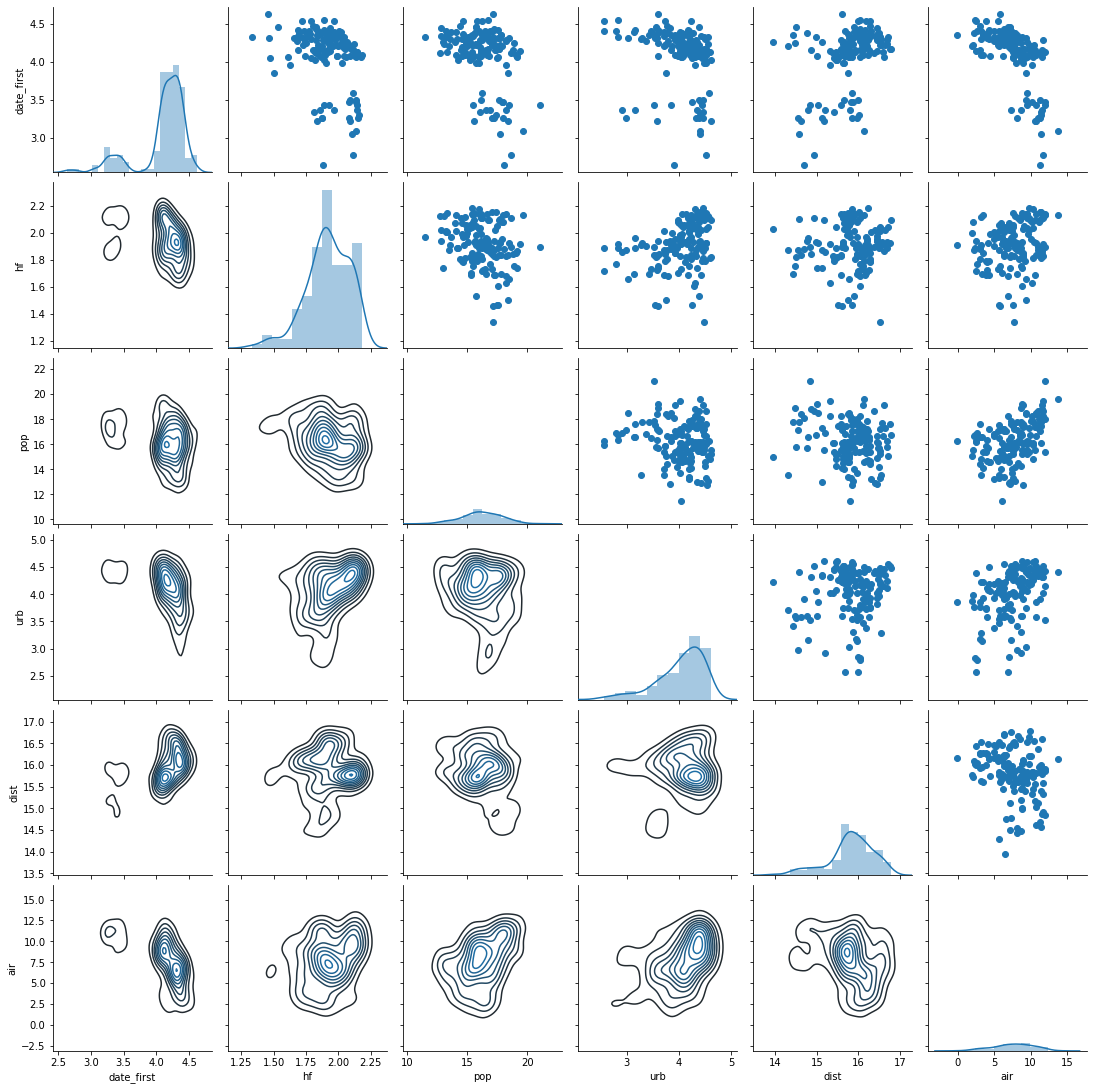

In [31]:
g = sns.PairGrid(X)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=True)
g = g.map_upper(plt.scatter)

In [60]:
stan_model = """
data {
    int N;
    real hf[N];
    real pop[N];
    real urb[N];
    real dist[N];
    real air[N];
    real Y[N];
    int<lower=0> N_new;
}

parameters {
    real h;
    real p;
    real u;
    real d;
    real a;
    real b;
    real<lower=0> sigma; 
}

model{
    real mu;
    for (n in 1:N){
        mu = h * hf[n] + p * pop[n] + u * urb[n] + d * dist[n] + a * air[n] + b;
        Y[n] ~ normal(mu, sigma);
    }
}
generated quantities {
    real Y_new[N_new];
    real mu_new;
    for (n in 1:N_new){
        mu_new = h * hf[n] + p * pop[n] + u * urb[n] + d * dist[n] + a * air[n] + b;
        Y_new[n] = normal_rng(mu_new, sigma);
    }
}
"""

In [61]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc061e76d2ac9a830fc09dab82e71091 NOW.


In [63]:
stan_data = {
    "N":X.shape[0],
    "hf":X["hf"],
    "pop":X["pop"],
    "urb":X["urb"],
    "dist":X["dist"],
    "air":X["air"],
    "Y":X["date_first"],
    "N_new":X.shape[0],
}

In [64]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=4, seed=123)

In [65]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_cc061e76d2ac9a830fc09dab82e71091.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
h          -0.69  2.5e-3   0.15  -0.98  -0.79  -0.69  -0.59   -0.4   3486    1.0
p          -0.07  3.2e-4   0.02   -0.1  -0.08  -0.07  -0.06  -0.03   3064    1.0
u          -0.09  1.1e-3   0.06  -0.22  -0.13  -0.09  -0.05   0.03   3041    1.0
d           0.21  7.9e-4   0.04   0.13   0.18   0.21   0.24   0.29   2903    1.0
a          -0.04  2.2e-4   0.01  -0.06  -0.05  -0.04  -0.03  -0.02   3065    1.0
b           3.88    0.01   0.77   2.38   3.36   3.88    4.4   5.35   2719    1.0
sigma       0.27  2.6e-4   0.02   0.24   0.26   0.27   0.28    0.3   4045    1.0
Y_new[1]    4.15  3.5e-3   0.27   3.62   3.97   4.15   4.33   4.69   5889    1.0
Y_new[2]     4.2  3.7e-3   0.28   3.65   4.

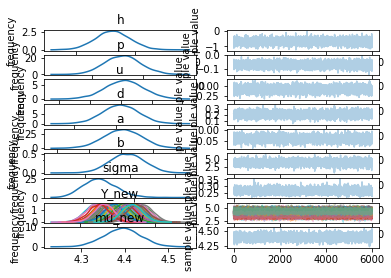

In [66]:
fig = fit.plot()

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (158), generating only 20 plots
  UserWarning,


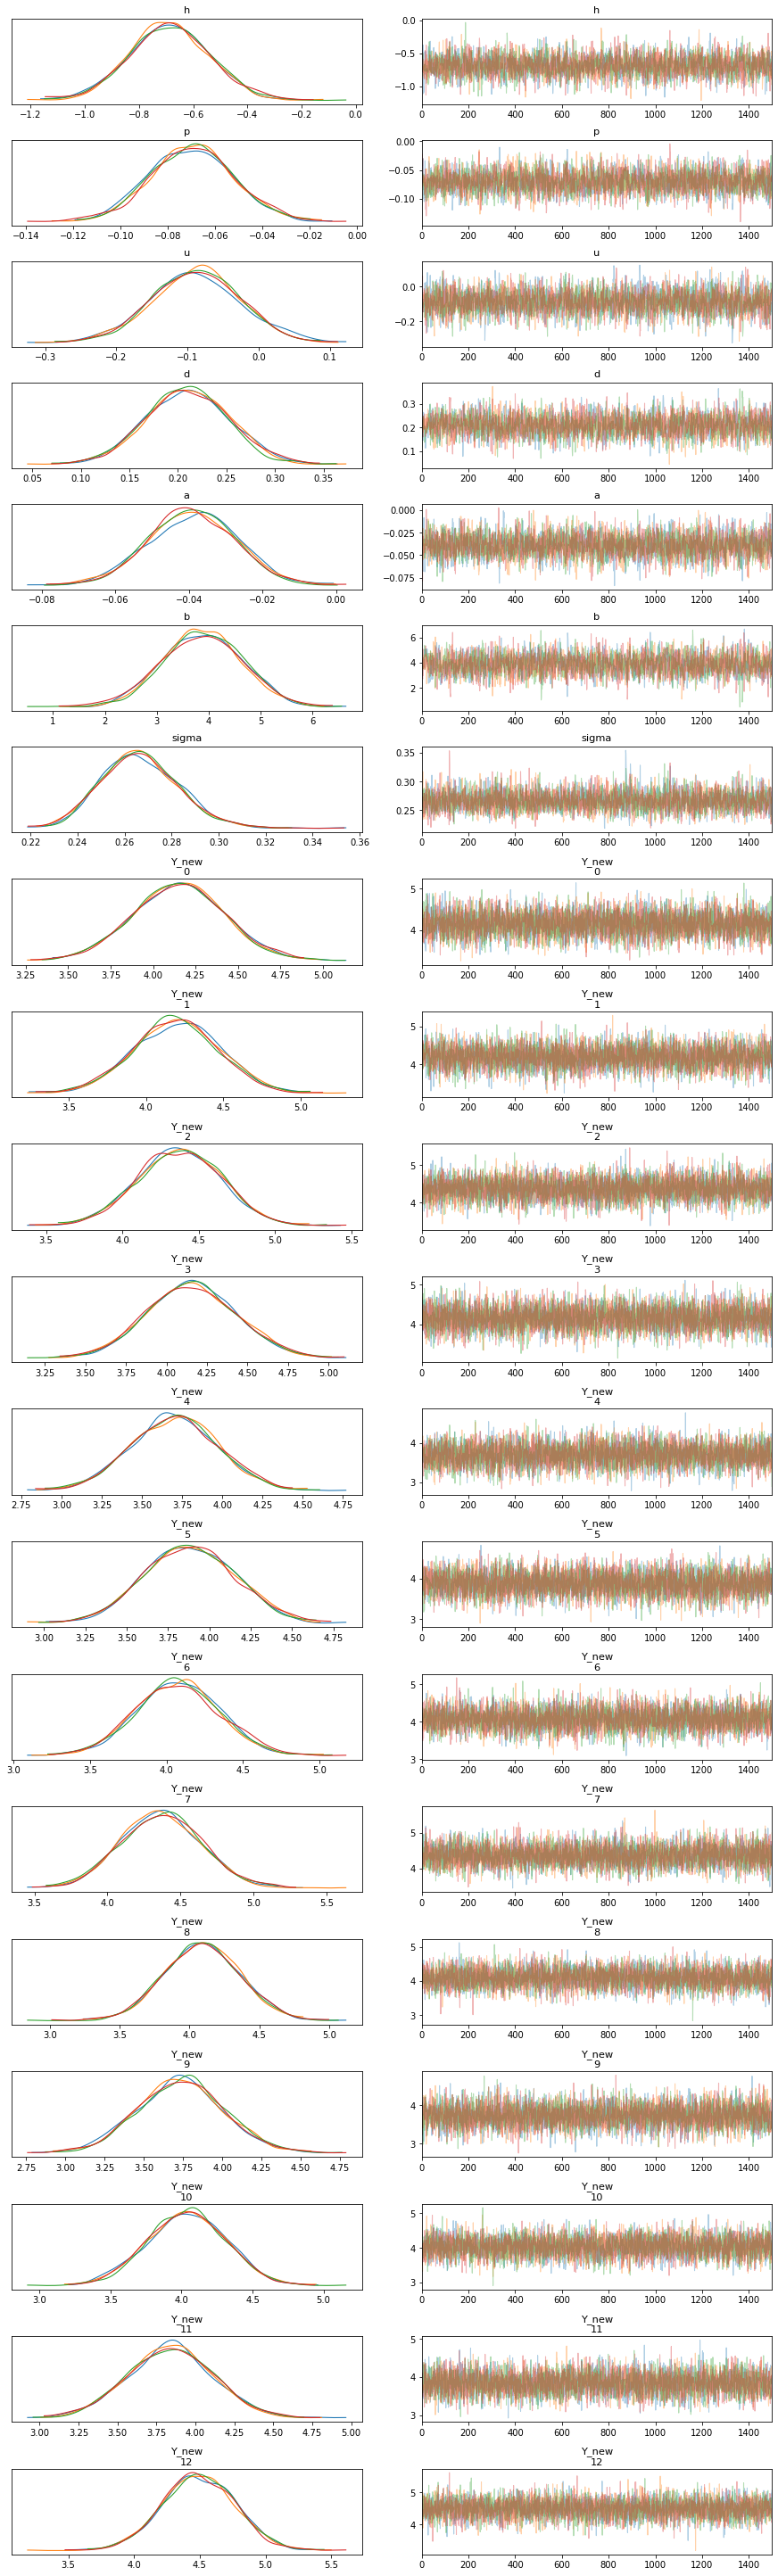

In [67]:
arviz.plot_trace(fit)
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = fit['Y_new'].mean(axis=0)
print('MSE(test) = {:.2f}'.format(mean_squared_error(np.exp(X["date_first"]), np.exp(y_pred))))
print('R^2(test) = {:.2f}'.format(r2_score(np.exp(X["date_first"]), np.exp(y_pred))))

MSE(test) = 168.15
R^2(test) = 0.49


(array([ 4.,  6., 12., 21., 21., 22., 22., 22., 17.,  3.]),
 array([3.40933751, 3.53571656, 3.66209561, 3.78847467, 3.91485372,
        4.04123277, 4.16761182, 4.29399087, 4.42036992, 4.54674897,
        4.67312802]),
 <a list of 10 Patch objects>)

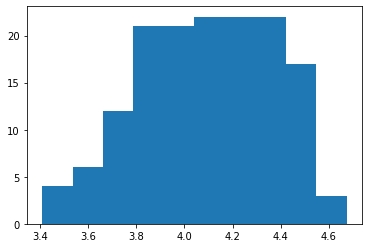

In [84]:
plt.hist(y_pred)

(array([ 2.,  0.,  4.,  9.,  8.,  0.,  6., 54., 57., 10.]),
 array([2.63905733, 2.83764888, 3.03624043, 3.23483197, 3.43342352,
        3.63201507, 3.83060662, 4.02919817, 4.22778972, 4.42638126,
        4.62497281]),
 <a list of 10 Patch objects>)

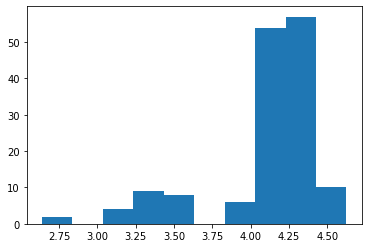

In [85]:
plt.hist(X["date_first"])